# ADA final exam (winter semester 2019/2020)

A friend of yours wants to start a YouTube channel and ideally earn some money via ads. However, there are so many channels and videos out there that your friend has no idea where to even start. Fortunately, they know that you have taken ADA and think you might help them out by analyzing the videos that are currently on YouTube.

The data you are provided with is a subset of YouTube videos, with videos from some of the giant channels in two categories: "Gaming" and "How-to & Style", which are the categories your friend is choosing between. The dataset contains a lot of videos, with data on those videos including their titles, their total number of views in 2019, their tags and descriptions, etc. The data is, in gzip-compressed format, contained in the `data/` folder, as the file `youtube.csv.gz`.

The three tasks A, B and C are **independent** of each other, and you can solve any combination of them. The exam is designed for more than 3 hours, so don't worry if you don't manage to solve everything; you can still score a 6.

You need to run the following two cells to read and prepare the dataset.

In [1]:
import pandas as pd
import numpy as np

In [2]:
youtube = pd.read_csv('data/youtube.csv.gz', compression='gzip')
youtube.upload_date = pd.to_datetime(youtube.upload_date)

## Dataset description

Each row of the dataset corresponds to one video that was uploaded to YouTube. There are 11 columns:
'channel', 'upload_date', 'title', 'categories', 'tags', 'duration',
       'view_count', 'average_rating', 'height', 'width', 'channel_cat'.
- `channel`: The channel (account) on which the video was uploaded.
- `upload_date`: The date on which the video was uploaded (Pandas Timestamp object).
- `title`: The title of the video.
- `tags`: A list of words that describe the video.
- `duration`: The duration of the video in seconds.
- `view_count`: The number of times the video was watched.
- `average_rating`: The average score with which the viewers rated the video (1-5).
- `height`: The height of the video in pixels.
- `width`: The width of the video in pixels.
- `channel_cat`: The category of the channel on which this video was uploaded. This dataset only contains videos from channels from the 'Gaming' and the 'Howto & Style' category.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Task A: Welcome to the exam!

All of Task A refers to the video that were published between and including 2010 and 2018.

## A1: A growing platform?

You would first like to know whether YouTube in general is the right platform to invest time into.

1. Using the appropriate plot type, plot the number of videos published per year between and including 2010 and 2018.

2. Now for each year, plot the number of channels that have been created between the beginning of 2010 and the end of that year. A channel is considered to be created at the time at which they upload their first video.

3. Normalize the number of videos published each year by the number of channels that have been created between the beginning of 2010 and the end of that year, and plot these quantities. Do seperate plots for gaming channels, how-to channels, and both together. Can you conclude from the plot that both gaming and how-to channels have been becoming less and less active recently? Why, or why not?

In [4]:
youtube.head()

,channel,upload_date,title,tags,duration,view_count,average_rating,height,width,channel_cat
0,PewDiePie,2013-03-04,A NEW ADVENTURE! - Kingdom Hearts (1) w/ Pewds,"['lets', 'play', 'horror', 'game', 'walkthroug...",1126.0,2541550.0,4.886102,720.0,1280.0,Gaming
1,PewDiePie,2013-03-04,SAVING PRIVATE PEWDS - Conker's Bad Fur Day (15),"['lets', 'play', 'horror', 'game', 'walkthroug...",903.0,1727646.0,4.951531,720.0,1280.0,Gaming
2,PewDiePie,2013-03-04,THE WORST SCARE! - Amnesia: Rain (4),"['lets', 'play', 'horror', 'game', 'walkthroug...",806.0,1402747.0,4.962706,720.0,1280.0,Gaming
3,PewDiePie,2013-03-03,Nova / Sp00n / Cry / Pewds - Worms Revolution ...,"['lets', 'play', 'horror', 'game', 'walkthroug...",909.0,4348296.0,4.937665,720.0,1280.0,Gaming
4,PewDiePie,2013-03-03,SEXIEST HORROR EVER - Amnesia: Rain (3),"['lets', 'play', 'horror', 'game', 'walkthroug...",834.0,1410659.0,4.957545,720.0,1280.0,Gaming


In [5]:
youtube.dtypes

channel                   object
upload_date       datetime64[ns]
title                     object
tags                      object
duration                 float64
view_count               float64
average_rating           float64
height                   float64
width                    float64
channel_cat               object
dtype: object

In [6]:
youtube['upload_year'] = youtube.upload_date.apply(lambda x: x.year)
youtube['upload_month'] = youtube.upload_date.apply(lambda x: x.month)

In [7]:
def calculate_per_year(df, categories, col, year_start, year_end, what='count',
                       keep_duplicates=True, duplicate_cols=None, cumulative=False):
    df_cleaned = df.loc[(df.channel_cat.apply(lambda x: x in categories))&
    (df.upload_year <= year_end) & (df.upload_year >= year_start), 
        ['upload_year', col]].sort_values('upload_year')
    if not keep_duplicates:
        df_cleaned = df_cleaned.drop_duplicates(subset=duplicate_cols, keep='first')
    if what == 'count':
        result_df = df_cleaned.groupby('upload_year').count() + \
            pd.DataFrame(data={col: [0]*(year_end-year_start+1), 
            'upload_year':list(range(year_start,year_end+1))}).set_index('upload_year')
    elif what == 'mean':
        result_df = df_cleaned.groupby('upload_year').mean()
    elif what == 'sum':
        result_df = df_cleaned.groupby('upload_year').sum()
    if cumulative:
        result_df = result_df.fillna(0).cumsum()
    return result_df

In [8]:
youtube.channel_cat.unique()

array(['Gaming', 'Howto & Style'], dtype=object)

In [9]:
cats_chosen = ['Gaming', 'Howto & Style']

## A1.1
The appropriate plot type is a bar chart.

Text(0, 0.5, 'videos')

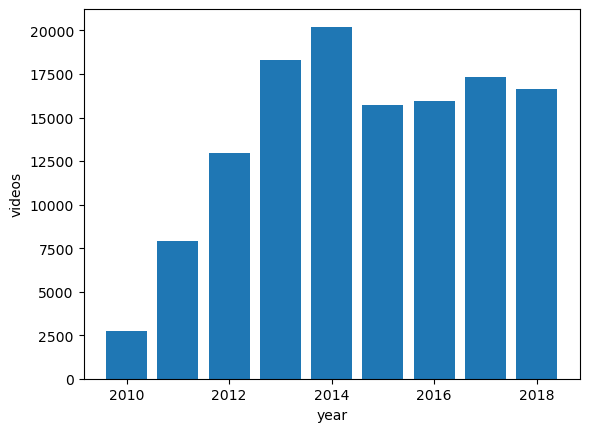

In [10]:
vids_per_year = [calculate_per_year(youtube, [x], 'title', 2010, 2018) for x in cats_chosen]
vids_per_year.append(calculate_per_year(youtube, cats_chosen, 'title', 2010, 2018))
titles = cats_chosen + ['Both']
#fig = plt.figure(figsize=(20,10))
plt.bar(x=vids_per_year[2].index, height=vids_per_year[2].title)
plt.xlabel('year')
plt.ylabel('videos')

## A1.2

Text(0, 0.5, 'channels')

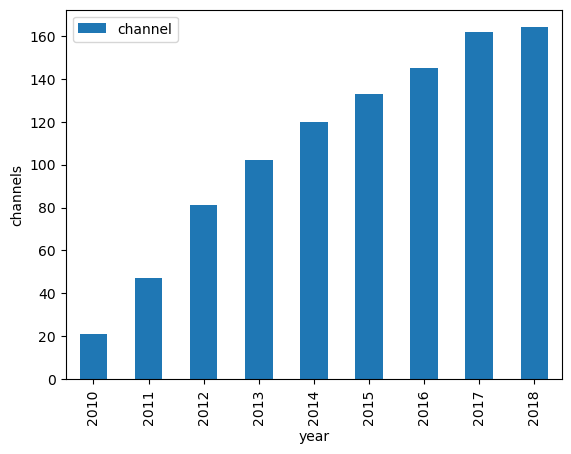

In [11]:
# We don't keep channels that have existed before 2010.
new_channels = youtube[~youtube.channel.isin(youtube.channel[youtube.upload_date < np.datetime64('2010-01-01')].unique())]
channels_per_year = calculate_per_year(new_channels, cats_chosen, 'channel', 2010, 2018, 
                                        keep_duplicates=False, duplicate_cols=['channel'],
                                        cumulative=True)

channels_per_year.plot(kind='bar')
plt.xlabel('year')
plt.ylabel('channels')

## A1.3

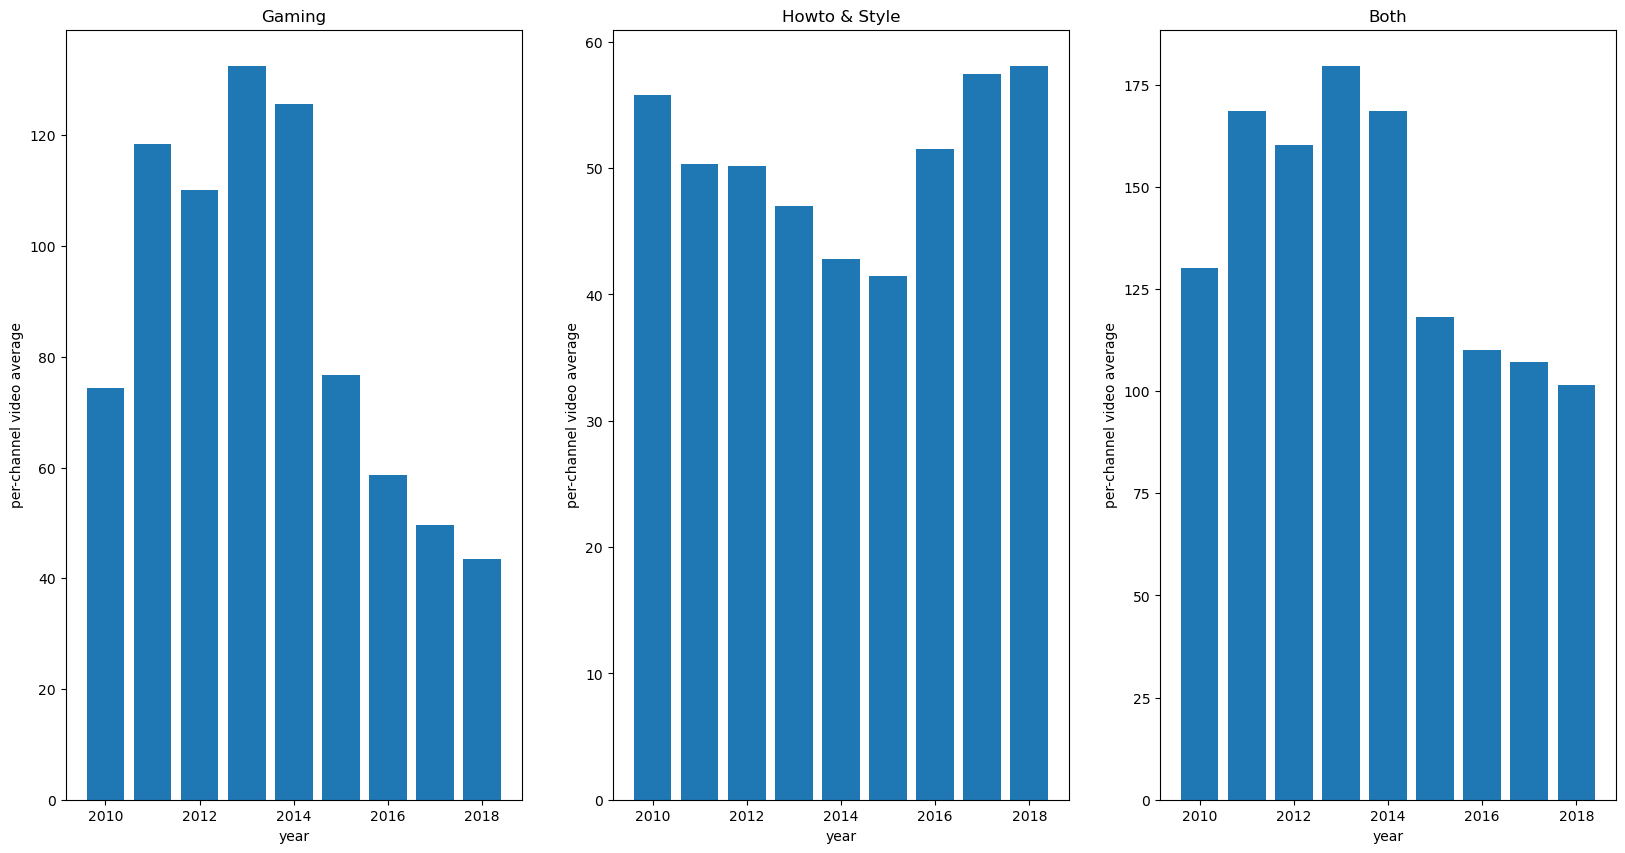

In [12]:
fig = plt.figure(figsize=(20,10))
for i in range(len(vids_per_year)):
    ax = fig.add_subplot(1,3,i+1)
    current_df = vids_per_year[i].join(channels_per_year).\
                    assign(avg_count=lambda x: x['title']/x['channel'])[['avg_count']]
    ax.bar(x=current_df.index, height=current_df.avg_count)
    ax.set_title(titles[i])
    ax.set_xlabel('year')
    ax.set_ylabel('per-channel video average')
#    ax.set_ylim([0,21000])


So together, it seems that activity has gone down, but truth is, gaming has gone down dramatically while howto has risen in recent years.

## A2: The one thing we all love: cash money

Your friend is really keen on making money from their YouTube channel through ads and wants you to help them choose the most profitable channel category (Gaming or Howto & Style). The ad profit is directly proportional to the number of views of a video.

1. Since your friend wants to keep producing videos for several years to come, it might also be worth looking at the growth of the two categories.
  1. Compute the total number of views in each category per year for the years 2010-2018.
  2. Divide the yearly view count by the number of channels that posted a video in each category in each year. Plot these normalized counts.




2. It takes some time for channels to become popular. For this question and all the following questions in A2, only consider channels that uploaded their first video in  2016 or later. Compute the total number of views in each category and divide it by the number of channels in that category.


3. The number of views might be very unevenly over the different channels, and channels might upload different numbers of videos.
  1. Compute the mean number of views per video for each channel.
  2. Compute the mean of these means for each of the two categories. Print these values.
  3. Using bootstrapping, compute 95% confidence intervals for these two means. From this analysis, can you draw a recommendation for one of the two categories? Why, or why not?

## A2.1
### (A)

In [13]:
youtube.loc[youtube.channel_cat == 'Gaming'].view_count.sum()

135986429274.0

In [14]:
youtube.loc[youtube.channel_cat == 'Howto & Style'].view_count.sum()

86493243255.0

### (B)

In [15]:
cat1_views = calculate_per_year(youtube, ['Gaming'], 'view_count', 2010, 2018, what='sum')
# cat1_views.plot(kind='bar')

In [16]:
cat2_views = calculate_per_year(youtube, ['Howto & Style'], 'view_count', 2010, 2018, what='sum')
# cat2_views.plot(kind='bar')

In [17]:
channels_cat1 = calculate_per_year(youtube, ['Gaming'], 'channel', 2010, 2018, 'count', keep_duplicates=False, 
                          duplicate_cols=['upload_year', 'channel'])
channels_cat2 = calculate_per_year(youtube, ['Howto & Style'], 'channel', 2010, 2018, 'count', keep_duplicates=False, 
                          duplicate_cols=['upload_year', 'channel'])

In [18]:
channels_cat1

,channel
upload_year,
2010,24
2011,41
2012,57
2013,66
2014,69
2015,63
2016,59
2017,54
2018,47


Text(0.5, 0, 'upload year')

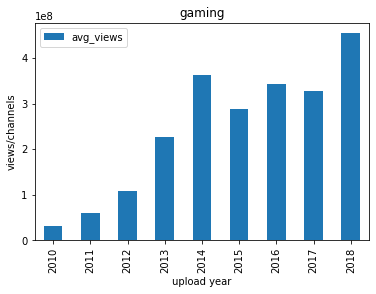

In [18]:
cat1_views.join(channels_cat1).assign(avg_views=lambda x: x['view_count']/x['channel'])[['avg_views']].\
                                plot(kind='bar')
plt.title('gaming')
plt.ylabel('views/channels')
plt.xlabel('upload year')

Text(0.5, 0, 'upload year')

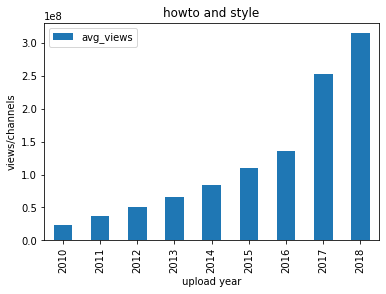

In [19]:
cat2_views.join(channels_cat2).assign(avg_views=lambda x: x['view_count']/x['channel'])[['avg_views']].\
                                plot(kind='bar')
plt.title('howto and style')
plt.ylabel('views/channels')
plt.xlabel('upload year')

## A2.2

In [20]:
channel_starts = youtube[['channel', 'upload_year']].groupby('channel').min().reset_index()
channels_late = channel_starts.loc[channel_starts.upload_year >= 2016].channel.values

In [21]:
channels_late

array(['5-Minute Crafts', '5-Minute Crafts GIRLY', '5-Minute Crafts PLAY',
       'Anaysa', 'Antonio Garza', 'BRICO SYMPA', 'BRIGHT SIDE', 'Blossom',
       'Ceeday', 'Chris Smoove', 'Clash Royale', 'Crafty Panda',
       'Daequan Loco', 'Denis', 'Frost Diamond', 'GameGrumps',
       'Grandpa Kitchen', 'Health Tips for You', 'Homemade solutions',
       'Hong Giang DIY Slime', 'Indian Health', 'Izabela Stress',
       'Jess No Limit', 'MeLlamanFredy', 'SHORT TIME SECRET',
       'Satisfying Slime Videos', 'So Yummy', 'Tasty', 'Tom Slime',
       'Xyz Gyan', 'YourHealth'], dtype=object)

In [22]:
len(youtube.loc[(youtube.channel_cat == 'Howto & Style') & 
            (youtube.channel.apply(lambda x: x in channels_late))].channel.unique())

23

In [23]:
len(youtube.loc[(youtube.channel_cat == 'Gaming') & 
             (youtube.channel.apply(lambda x: x in channels_late))].channel.unique())

8

These two are the answers to A2:

In [24]:
youtube.loc[(youtube.channel_cat == 'Howto & Style') & 
            (youtube.channel.apply(lambda x: x in channels_late))].view_count.sum() / \
            len(youtube.loc[(youtube.channel_cat == 'Howto & Style') & 
            (youtube.channel.apply(lambda x: x in channels_late))].channel.unique())

1374135339.0

In [25]:
youtube.loc[(youtube.channel_cat == 'Gaming') & 
            (youtube.channel.apply(lambda x: x in channels_late))].view_count.sum() /\
            len(youtube.loc[(youtube.channel_cat == 'Gaming') & 
             (youtube.channel.apply(lambda x: x in channels_late))].channel.unique())

895409422.375

Now let's look at the aggregation, per channel. For this aggregation, there are two solutions:
* If you consider the effort spent for each video to be similar, then the average.
* If you only want to consider the total potential revenue, then the sum.

## A2.3A

In [26]:
howto_perchannel_new = youtube.loc[(youtube.channel_cat == 'Howto & Style') & 
            (youtube.channel.apply(lambda x: x in channels_late)), ['view_count', 'channel']].\
            groupby('channel').mean().view_count.values

In [27]:
gaming_perchannel_new = youtube.loc[(youtube.channel_cat == 'Gaming') & 
            (youtube.channel.apply(lambda x: x in channels_late)), ['view_count', 'channel']].\
            groupby('channel').mean().view_count.values

## A2.3B

In [28]:
np.mean(howto_perchannel_new), np.mean(gaming_perchannel_new)

(3371299.2233319054, 1404771.1416982808)

## A2.3C

In [29]:
def do_bootstrap(data, n=1000):
    sample_statistic = [] 
    for _ in range(n):
        sampled_data = np.random.choice(data, size=len(data))  
        sample_statistic.append(np.mean(sampled_data))
    return (np.percentile(sample_statistic, 2.5), np.percentile(sample_statistic, 97.5))

In [30]:
[do_bootstrap(howto_perchannel_new), do_bootstrap(gaming_perchannel_new)]

[(2150921.048323673, 4883514.941399923),
 (941627.6695806755, 1898984.9410688933)]

The difference is significant, as the two confidence intervals have no overlap.

# Task B: View forecasting (Machine Learning)

Your friend wants to figure out how they can optimize their videos for getting the maximum number of views (without using shocking thumbnails and clickbait titles). In this task, you will build a machine learning (ML) model for predicting the success of a video.

## B1: Get those shovels out again

1. For the prediction model, use all rows of the dataset, but keep only the following columns: `view_count, channel, upload_date, duration, average_rating, height, width`.

In [31]:
ml_columns = ['view_count', 'channel', 'upload_date', 'duration', 'average_rating', 'height', 'width']
youtube_ml = youtube[ml_columns].copy()

2. Extract the upload year and upload month from the `upload_date` column into the two columns `upload_year` and `upload_month`, and remove `upload_date`.

In [32]:
youtube_ml['u_year'] = youtube_ml.upload_date.dt.year
youtube_ml['u_month'] = youtube_ml.upload_date.dt.month
youtube_ml = youtube_ml.drop(columns=['upload_date'])

3. The entry in the channel column for a video indicates on which channel the video was uploaded. Encode this column via one-hot encoding.

In [33]:
youtube_ml = pd.get_dummies(youtube_ml, columns=['channel'], prefix='channel_')

4. Split the data into a train (70%) and a test set (30%) with the appropriate function from sklearn, using 42 as the random seed.

In [34]:
train, test = train_test_split(youtube_ml, test_size=0.3, random_state=42)

## B2: Who is the most viewed of them all?

1. Train a ridge regression model (i.e., an L2-regularized linear regression model) on the train set that predicts the view count from the other features. Find and use the optimal regularization parameter $\alpha$ from the set {0.001, 0.01, 0.1} via 3-fold cross validation.

In [35]:
X_train = train.drop(columns=['view_count'])
y_train = train['view_count']
X_test = test.drop(columns=['view_count'])
y_test = test['view_count']

In [36]:
ridge = Ridge()
ridge_hyper = {'alpha':(0.001, 0.01, 0.1)}
ridge_cv = GridSearchCV(ridge, ridge_hyper, cv=3)
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': (0.001, 0.01, 0.1)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [37]:
ridge_cv.cv_results_['mean_test_score']

array([0.08010146, 0.08010271, 0.0801151 ])

2. Report the mean absolute error that the model makes on the test set.

In [38]:
mean_absolute_error(y_test, ridge_cv.predict(X_test))

1444649.5039951615

## B3: Checking our ambitions

To improve performance, you want to make the task of the ML model easier and turn it into a classification task. Now it only has to predict whether a video has a high view count (defined as being larger than the median of the view counts in the training set) or a low view count (defined as being smaller or equal to the median of the view counts in the training set).

1. Train a logistic regression model for this classification task. Find and use the optimal regularization parameter C (as defined in scikit-learn's documentation) from the set {1, 10, 100} via 3-fold cross validation. Use the random seed 42. _Hint_: If you get a warning about the training algorithm failing to converge, increase the maximum number of training iterations.

In [39]:
threshold = y_train.median()

y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

In [40]:
Cs = (1, 10, 100)
log_reg_cv = LogisticRegressionCV(Cs=Cs, cv=3, random_state=42, max_iter=200)

In [41]:
log_reg_cv.fit(X_train, y_train_binary)
opt_C = log_reg_cv.C_[0]
opt_C

10

In [42]:
log_reg_cv.scores_[1].mean(axis=0)

array([0.74790585, 0.74791609, 0.74790585])

2. Compute the accuracy of the logistic regression model on the test set.

In [43]:
log_reg_cv.score(X_test, y_test_binary)

0.7479033761020716

## B4: ...something's not right.

You are satisfied with the model performance. In fact, you are a bit surprised at how good the model is given the relatively little amount of information about the videos. So you take a closer look at the features and realize that the (one-hot-encoded) channel feature does not make sense for the application that your friend has in mind.

1. Why does the channel feature not make sense?

Even though your friend knows who will upload their videos (your friend, of course), no video with this channel is in the training set and thus the corresponding one-hot feature does not exist in the model. Thus they wouldn't be able to use the trained model for predictions on their own videos.

2. Train another logistic regression model with all the features from B3 except the one-hot-encoded channel. Use again 42 as the seed for the train test split and perform the same hyperparameter optimization as in B3. How does the model performance change?

In [44]:
youtube_ml = youtube_ml[['view_count', 'duration', 'average_rating', 'height', 'width', 'u_year', 'u_month']]
train, test = train_test_split(youtube_ml, test_size=0.3, random_state=42)
X_train = train.drop(columns=['view_count'])
y_train = train['view_count']
X_test = test.drop(columns=['view_count'])
y_test = test['view_count']

threshold = y_train.median()

y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

In [45]:
log_reg_cv.fit(X_train, y_train_binary)
opt_C = log_reg_cv.C_[0]
opt_C

100

In [46]:
log_reg_cv.score(X_test, y_test_binary)

0.6075311208276587

Without the channel, the accuracy drops by 15 percentage points, and is not that far from uniformly random prediction anymore.

## B5: "We kinda forgot about categories."

On second thought, there is actually one feature that you may use about the channel. Namely, the channel category. The reason this one makes sense might also help you answer B4.1.

1. Train and evaluate another logistic regression model (in the same way as in B4 regarding train/test split and hyperparameter) that additionally includes the one-hot-encoded channel category.

In [47]:
youtube_ml['channel_cat'] = youtube['channel_cat']
youtube_ml = pd.get_dummies(youtube_ml, columns=['channel_cat'], prefix='cat_')

train, test = train_test_split(youtube_ml, test_size=0.3, random_state=1)
X_train = train.drop(columns=['view_count'])
y_train = train['view_count']
X_test = test.drop(columns=['view_count'])
y_test = test['view_count']

threshold = y_train.median()

y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

In [48]:
log_reg_cv.fit(X_train, y_train_binary)
opt_C = log_reg_cv.C_[0]
opt_C

1

In [49]:
log_reg_cv.score(X_test, y_test_binary)

0.6133610493871408

2. The dynamics of the two categories might differ a lot, and the two communities might value different properties of a video differently. For instance, for one community, a long duration might be more important, for the other one, a large picture width. Thus, having only a single weight for, e.g., the duration of a video, might not give the best results. Is there something smarter that you can do than simply including the category as a single one-hot-encoded feature to improve the classification performance? Implement your idea and compare the accuracy on the test set with that of the first model (from task B5.1).

---

We can instead train two separate models, one for each category.

In [50]:
youtube_ml = youtube_ml[['view_count', 'duration', 'average_rating', 'height', 'width', 'u_year', 'u_month']]
youtube_ml_gaming = youtube_ml[youtube['channel_cat'] == 'Gaming']
youtube_ml_howto = youtube_ml[youtube['channel_cat'] == 'Howto & Style']

In [51]:
train_gaming, test_gaming = train_test_split(youtube_ml_gaming, test_size=0.3, random_state=1)
X_train_gaming = train_gaming.drop(columns=['view_count'])
y_train_gaming = train_gaming['view_count']
X_test_gaming = test_gaming.drop(columns=['view_count'])
y_test_gaming = test_gaming['view_count']

train_howto, test_howto = train_test_split(youtube_ml_howto, test_size=0.3, random_state=1)
X_train_howto = train_howto.drop(columns=['view_count'])
y_train_howto = train_howto['view_count']
X_test_howto = test_howto.drop(columns=['view_count'])
y_test_howto = test_howto['view_count']

In [52]:
y_train_binary_gaming = (y_train_gaming > y_train_gaming.median()).astype(int)
y_test_binary_gaming = (y_test_gaming > y_train_gaming.median()).astype(int)
y_train_binary_howto = (y_train_howto > y_train_howto.median()).astype(int)
y_test_binary_howto = (y_test_howto > y_train_howto.median()).astype(int)

Training separate models for the two categories gives slightly better accuracies.

First for the gaming category:

In [53]:
log_reg_cv.fit(X_train_gaming, y_train_binary_gaming)
log_reg_cv.score(X_test_gaming, y_test_binary_gaming)

0.6309681034137752

And then for the howto category:

In [54]:
log_reg_cv.fit(X_train_howto, y_train_binary_howto)
log_reg_cv.score(X_test_howto, y_test_binary_howto)

0.6477528756077315

# Task C: A map of the channels (Graphs)

Your friend wants to map out the channels and represent their similarities. For this purpose, we have created two undirected and unweighted graphs for you, where in each graph, each channel has a node and similar channels have edges connecting them. In one graph, the similarity between two channels is based on how similar their video descriptions are, while in the other, the similarity is based on how similar their video tags are. We will call the former $G_{text}$ and the latter $G_{tags}$. You will be analyzing the two graphs loaded by running the cell below.

In [55]:
from networkx import from_numpy_array
import json
g_text_adj = np.loadtxt(open('data/g_text_adj.csv', 'r'), delimiter=',', skiprows=0)
g_tags_adj = np.loadtxt(open('data/g_tags_adj.csv', 'r'), delimiter=',', skiprows=0)
channel_to_index = json.load(open('data/channel_indices.json', 'r'))
g_text = from_numpy_array(g_text_adj)
g_tags = from_numpy_array(g_tags_adj)

## C1: Does YouTube have a content diversity problem?

1. For each graph, calculate its diameter (i.e., the largest shortest-path length, where the maximization is done over all node pairs). What difference do you see? _Hint_: Don't worry if you get an error, just read the error message carefully.

2. What does the diameter of $G_{text}$ say about the diversity of the channels’ contents? How about the diameter of $G_{tags}$?

3. Based on what you have calculated, which one has greater diversity: descriptions used by channels, or tags used by channels? Justify your answer.

4. Imagine that you want to **compare** content diversity between two sets of channels (i.e., you want to see which set of channels has more diverse content), and you have calculated a tag-based graph for each set. Do you think the diameter is a good measure for doing the comparison? Justify your answer.

5. Back to our own two graphs. Based on $G_{text}$, for each category of channels, which channel is the one most representative of the contents of all channels in that category? In other words, for each category, if you needed to provide a summary of all channels in the category via one channel, which channel would you choose? Show us (us being the exam designers and your friend) the descriptions of this channel’s two most-viewed videos. What metric did you use for this purpose? Explain your choice.

## C2: Going back to categories again

1. We want to use the two graphs to cluster channels from the same category together, and we want to compare their effectiveness at doing so. Use Kernighan-Lin bisection in the networkx package (`networkx.algorithms.community.kernighan_lin_bisection`) to divide each graph into two communities. Use 42 as the random seed. For each graph, show how many members of each category fall into each of the two communities.

2. If one of these graphs were ideal for this clustering task, what would the resulting communities look like? If it were the absolute worst possible graph for the task, what would the resulting communities look like?

3. Calculate the probability $P(community|category)$ for each community and category within each graph. Design a metric, using the four $P(community|category)$ values in a graph, whose value would be 1 for the ideal graph and 0 for the worst graph. Calculate this metric for both graphs and compare the two. What do the results say about how representative tags and descriptions are regarding the channel categories? Are tags better suited, or descriptions?

4. The Kernighan-Lin bisection you used above performs a min-edge cut: It attempts to partition the nodes of the graph into two sets of almost-equal size by deleting as few edges as possible. It starts off by creating a random partition of the nodes of the graph into two sets A and B that are almost equal in size, and then iteratively and in a greedy fashion moves nodes between A and B to reduce the number of edges between A and B. Show at least one toy example of a graph where the initialization could also be the final result. (Hint: Think of how, as we explained, the bisection algorithm relies on a minimum edge cut with a random initialization; under what circumstances could the original A and B be the best partition given that graph?)

## Beginning of solution for C

In [71]:
import networkx
g_text_adj = np.loadtxt(open('data/g_text_adj.csv', 'r'), delimiter=',', skiprows=0)
g_tags_adj = np.loadtxt(open('data/g_tags_adj.csv', 'r'), delimiter=',', skiprows=0)
channel_to_index = json.load(open('data/channel_indices.json', 'r'))
g_text = networkx.from_numpy_array(g_text_adj)
g_tags = networkx.from_numpy_array(g_tags_adj)

## C1.1

In [72]:
networkx.diameter(g_text)

2

In [73]:
networkx.diameter(g_tags)

NetworkXError: Found infinite path length because the graph is not connected

$G_{text}$ has a diameter of 2, while $G_{tags}$ is unconnected.

## C1.2
What the diameter says in case of $G_{text}$ is that thethe longest shortest path is just 2 edges long, which could mean relatively low diversity, while $G_{tags}$ doesn't tell us much because its diameter is undefined.

## C1.3
The tags are more diverse because the graph is unconnected.

In [74]:
networkx.number_connected_components(g_text)

1

In [75]:
networkx.number_connected_components(g_tags)

2

## C1.4
No, because as we saw, the diameter can end up being undefined for both, which implies that both are diverse but does not provide much of a comparison.

## C1.5
They can use either betweenness centrality (number of shortest paths passing through the node, i.e. the channel) or just the degree. Here we use the former.

In [76]:
centralities = networkx.betweenness_centrality(g_text)

In [77]:
highest_centrality_node = sorted(centralities.keys(), key=lambda x: centralities[x], reverse=True)[0]

In [78]:
highest_centrality_node

1

In [79]:
{v:k for k,v in channel_to_index.items()}[highest_centrality_node]

'Desi Perkins'

In [80]:
youtube.loc[youtube.channel == 'Desi Perkins'].sort_values('view_count', ascending=False).head(2)

,channel,upload_date,title,tags,duration,view_count,average_rating,height,width,channel_cat,upload_year,upload_month
137477,Desi Perkins,2014-05-04,EYEBROW TUTORIAL,"['how to', 'makeup', 'tutorial']",528.0,16851339.0,4.922917,1080.0,1920.0,Howto & Style,2014,5
137267,Desi Perkins,2017-08-16,KIM KARDASHIAN WEST MAKEUP TUTORIAL + NEW KKW ...,[],1499.0,8925152.0,4.888759,1080.0,1920.0,Howto & Style,2017,8


## C2.1

In [81]:
cats_df = youtube.loc[(youtube.channel_cat == 'Gaming') | (youtube.channel_cat == 'Howto & Style'), 
                   ['channel', 'channel_cat']].drop_duplicates(subset='channel')
cats_dict = {channel_to_index[cats_df.channel.values[i]]: cats_df.channel_cat.values[i] 
             for i in range(cats_df.shape[0])}
cats_dict = {k:1 if v == 'Gaming' else 0 for k,v in cats_dict.items()}

In [82]:
from networkx.algorithms.community import kernighan_lin_bisection

In [83]:
def calculate_community_probabilities(bisection, category, channel_cats):
    total_cat = len([x for x in channel_cats if channel_cats[x] == category])
    p_com1_cat = len([x for x in bisection[0] if channel_cats[x] == category]) / total_cat
    p_com2_cat = len([x for x in bisection[1] if channel_cats[x] == category]) / total_cat
    return p_com1_cat, p_com2_cat, p_com1_cat*total_cat, p_com2_cat*total_cat

In [84]:
text_graph_bisection = kernighan_lin_bisection(g_text, max_iter=100, seed=42)
tag_graph_bisection = kernighan_lin_bisection(g_tags, max_iter=100, seed=42)

In [85]:
#networkx.connected_components(g_tags)

### For $G_{text}$ 

Percentages and numbers (% in first community, % in second community, # in first, # in second):

**Gaming:**

In [86]:
calculate_community_probabilities(text_graph_bisection, 1, cats_dict)

(0.5252525252525253, 0.47474747474747475, 52.00000000000001, 47.0)

**Howto & Style**

In [87]:
calculate_community_probabilities(text_graph_bisection, 0, cats_dict)

(0.46875, 0.53125, 45.0, 51.0)

### For $G_{tags}$ 

Percentages and numbers (% in first community, % in second community, # in first, # in second):

**Gaming:**

In [88]:
calculate_community_probabilities(tag_graph_bisection, 1, cats_dict)

(0.7676767676767676, 0.23232323232323232, 76.0, 23.0)

**Howto & Style**

In [89]:
calculate_community_probabilities(tag_graph_bisection, 0, cats_dict)

(0.21875, 0.78125, 21.0, 75.0)

## C2.2
The ideal communities would be such that each would contain only **one** category. The worst communities would be evenly split between the two categories (i.e. 50% gaming and 50% howto).

## C2.3
Check the results in C2.1, the percentages were provided as well.

For the metric, one could be:
$$1 - 2*min_{community, category}\{P(community|category)\}$$

which would yield 1 if one of the probabilities is 0, and yield 0 if they are all 0.5.

For the two graphs we have, they can simply spot the minimum and calculate this metric, which would yield the following:

In [90]:
# G_text
1 - 2*.3125

0.375

In [91]:
# G_tags
1 - 2*.1458

0.7083999999999999

Based on this, $G_{tags}$ is quite superior in its discrimination between the two categories.

## C2.4

A case where the initialisation would also be the final result would be when we have a graph with two connected components, and where each community in the initialisation is one of the two connected components. Since this is a bipartition with no edge deletions, it essentially is a local minimum of the algorithm and is also the final result.